# **Librerías**


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
#@title librerias

!pip install pandas
!pip install scikit-learn
!pip install skforecast
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.4/384.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#@title uso librerias

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# **Datos**

In [6]:
# Descarga de datos
# ==============================================================================
arch = ('drive/MyDrive/MATRICES/completo_ok.csv')
datos = pd.read_csv(arch)

# Conversión del formato fecha
# ==============================================================================
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos = datos.set_index('Fecha')
datos = datos.asfreq('60min')
datos = datos.sort_index()
datos.info()
datos.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7297 entries, 2021-07-01 00:00:00 to 2022-05-01 00:00:00
Freq: 60T
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   float64
 1   Dia          7295 non-null   float64
 2   Demanda      7295 non-null   float64
 3   Temperatura  7295 non-null   float64
 4   Feriado      7295 non-null   float64
 5   Publico      7295 non-null   float64
dtypes: float64(6)
memory usage: 399.1 KB


,ID,Dia,Demanda,Temperatura,Feriado,Publico
Fecha,,,,,,
2021-07-01 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0
2021-07-01 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0
2021-07-01 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0
2021-07-01 03:00:00,3.0,4.0,1.653973e+09,7.7,0.0,0.0
2021-07-01 04:00:00,4.0,4.0,1.653886e+09,7.2,0.0,0.0


In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

In [ ]:
#Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2021-07-01 00:00:00': '2022-05-01 23:00:00']
fin_train = '2022-01-31 23:59:00'
fin_validacion = '2022-03-31 00:00:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# **Crear model.pkl**

In [31]:
import pickle
from lightgbm import LGBMRegressor  


def entrenar_y_guardar_modelo(datos):
    # Crear una nueva instancia de LGBMRegressor con los hiperparámetros encontrados
    regressor = LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=500)

    # Crear una nueva instancia de ForecasterAutoreg con el nuevo regressor
    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags = 7
                )

    forecaster.fit(y=datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'])

    # Guardar el modelo entrenado en un archivo
    with open('model.pkl', 'wb') as file:
        pickle.dump(forecaster, file)

entrenar_y_guardar_modelo(datos)


# **Prueba model.pkl con datos recolectados**


In [32]:
#@title prueba
# Backtesting
# Tener en cuenta subir el archivo model.pkl
# ==============================================================================

def make_predictions(model_file, data, initial_train_size=47, steps=7, interval=[10, 90], n_boot=1000):
    # Load the serialized model from the file
    with open(model_file, 'rb') as file:
        forecaster = pickle.load(file)

    # Make predictions using the loaded model
    metric, predictions = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = data,
                                initial_train_size = initial_train_size,
                                fixed_train_size   = False,
                                steps      = steps,
                                refit      = True,
                                interval   = interval,
                                n_boot     = n_boot,
                                metric     = 'mean_squared_error',
                                verbose    = False
                          )

    return predictions

In [33]:
predictions = make_predictions('model.pkl', datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'])
predictions.head(4)

  0%|          | 0/107 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2021-10-02 23:00:00,4.685564e+09,1.081363e+09,8.942916e+09
2021-10-03 00:00:00,4.685564e+09,1.081363e+09,9.252964e+09
2021-10-03 01:00:00,4.685564e+09,6.789309e+08,9.252964e+09
2021-10-03 02:00:00,4.685564e+09,1.041119e+09,8.942916e+09


In [34]:
#@title Cobertura del intervalo
# Cobertura del intervalo en los datos de test
# ==============================================================================

def calculate_coverage(predictions, data):
    # Calculate the coverage of the interval in the test data
    inside_interval = np.where(
                         (data.loc[predictions.index, 'Demanda'] >= predictions['lower_bound']) & \
                         (data.loc[predictions.index, 'Demanda'] <= predictions['upper_bound']),
                         True,
                         False
                      )

    coverage = inside_interval.mean()
    return coverage

In [35]:
coverage = calculate_coverage(predictions, datos)
print(f"Cobertura del intervalo predicho con los datos de test: {100 * coverage}")

Cobertura del intervalo predicho con los datos de test: 56.241610738255034


In [36]:
#@title grafico
# Gráfico
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_energy_demand(datos, predictions, figsize=(11, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'].plot(ax=ax, label='Demanda', linewidth=3, color="#23b7ff")
    ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        color = 'deepskyblue',
        alpha = 0.3,
        label = '80% interval'
    )
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_ylabel('MW')
    ax.set_title('Predicción de la demanda energética')
    ax.legend()

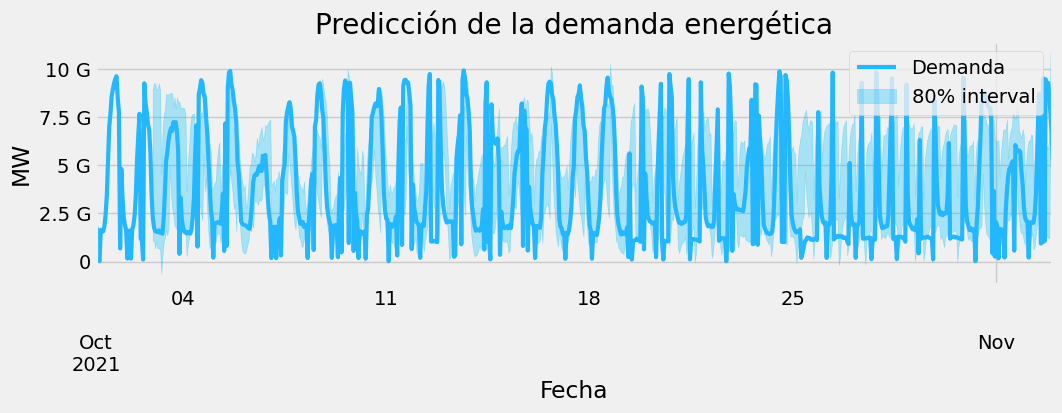

In [28]:
plot_energy_demand(datos, predictions)

In [29]:
from sklearn.metrics import mean_squared_error

def calculate_mse(datos, predictions):
    error_mse = mean_squared_error(
        y_true = datos.Demanda['2021-10-01 00:00':'2021-11-01 00:00'],
        y_pred = predictions.iloc[:, 0]
    )
    return error_mse


In [30]:
error_mse = calculate_mse(datos, predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 7.91099277887778e+18
